In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
#import libraries
import cv2
import numpy as np
import os
from ultralytics import YOLO
from concurrent.futures import ProcessPoolExecutor, as_completed
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [ ]:
# #selected random images for objectd etection\
# #selected random images for YOLO + GrabCut = Segmnetion
# # Paths
# data_folder = "/content/drive/MyDrive/Thesis/POM-IMG/Data-14.10.2024"  # Replace with the path to your DATA folder
# destination_folder = "/content/drive/MyDrive/Thesis/POM-IMG/pom_seg"  # Replace with your destination folder

# # Create the destination folder if it doesn't exist
# os.makedirs(destination_folder, exist_ok=True)

# # Initialize a counter for renaming frames
# frame_count = 763

# # Iterate over each subfolder in the DATA folder
# for subfolder in os.listdir(data_folder):
#     subfolder_path = os.path.join(data_folder, subfolder)

#     # Check if it's a folder
#     if os.path.isdir(subfolder_path):
#         # Look for the 'Canon' folder inside the subfolder
#         canon_folder_path = os.path.join(subfolder_path, "Crop_RGB")

#         if os.path.isdir(canon_folder_path):
#             # Get all files in the Canon subfolder
#             files = [f for f in os.listdir(canon_folder_path) if os.path.isfile(os.path.join(canon_folder_path, f))]

#             # Select two random files
#             selected_files = random.sample(files, min(3, len(files)))

#             for file in selected_files:
#                 file_path = os.path.join(canon_folder_path, file)
#                 # Define new name and destination path
#                 new_name = f"FRAME {frame_count}.jpg"  # Adjust extension if not .jpg
#                 destination_path = os.path.join(destination_folder, new_name)

#                 # Copy the file to the destination folder
#                 shutil.copy(file_path, destination_path)

#                 # Increment the frame counter
#                 frame_count += 1

# print(f"Successfully moved and renamed {frame_count - 1} files.")

In [ ]:
def yolo_predict(model, image_path):

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image {image_path}")
        return []

    # Perform prediction
    results = model.predict(image, verbose=False, conf = 0.30)

    # Extract all detected bounding boxes
    bboxes = []
    if len(results[0].boxes) > 0:
        for box in results[0].boxes:
            x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)
            bboxes.append((x, y, w, h))
    else:
        print("No objects detected by YOLO.")

    return bboxes

def grabcut_single_bbox(image_path, bbox):

    # Load the original image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image {image_path}")
        return None

    # Shrink the bounding box slightly
    shrink_factor = 0.05
    x, y, w, h = bbox
    x += int(w * shrink_factor)
    y += int(h * shrink_factor)
    w -= int(w * shrink_factor * 2)
    h -= int(h * shrink_factor * 2)
    rect = (x, y, w, h)

    # Initialize mask, background, and foreground models
    mask = np.zeros(image.shape[:2], np.uint8)
    bg_model = np.zeros((1, 65), np.float64)
    fg_model = np.zeros((1, 65), np.float64)

    # Apply GrabCut
    cv2.grabCut(image, mask, rect, bg_model, fg_model, iterCount=7, mode=cv2.GC_INIT_WITH_RECT)

    # Create binary mask
    mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    return mask

def grabcut_with_agents(image_path, output_path, bboxes, num_agents):

    combined_mask = np.zeros(cv2.imread(image_path).shape[:2], np.uint8)

    # Use ProcessPoolExecutor to parallelize GrabCut for bounding boxes
    with ProcessPoolExecutor(max_workers=num_agents) as executor:
        future_to_bbox = {executor.submit(grabcut_single_bbox, image_path, bbox): bbox for bbox in bboxes}

        for future in as_completed(future_to_bbox):
            bbox = future_to_bbox[future]
            try:
                mask = future.result()
                if mask is not None:
                    combined_mask = cv2.bitwise_or(combined_mask, mask)
            except Exception as e:
                print(f"Error processing bounding box {bbox}: {e}")

    # Save the binary mask only
    cv2.imwrite(output_path, combined_mask * 255)  # Save binary mask as an image
    print(f"Saved binary mask to {output_path}")

def process_folder(input_folder, output_folder, model, num_agents, start_frame=0):

    os.makedirs(output_folder, exist_ok=True)

    file_list = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    file_list.sort()

    for idx, file_name in enumerate(file_list):
        if idx < start_frame:
            print(f"Skipping frame {idx}: {file_name}")
            continue

        input_path = os.path.join(input_folder, file_name)
        output_path = os.path.join(output_folder, file_name)

        if os.path.exists(output_path):
            print(f"Mask already exists for {file_name}, skipping.")
            continue

        print(f"Processing frame {idx + 1}/{len(file_list)}: {file_name}")

        # Perform YOLO detection and get the bounding boxes
        bboxes = yolo_predict(model, input_path)

        print(f"Detected {len(bboxes)} objects in {file_name}.")

        # If bounding boxes are detected, apply GrabCut with agents
        if bboxes:
            grabcut_with_agents(input_path, output_path, bboxes, num_agents)

if __name__ == "__main__":
    # Load YOLO model (e.g., YOLOv8)
    model = YOLO("/content/drive/MyDrive/Thesis/POM-IMG/Results_FT_TL/finetuned_model.pt")

    # Define input and output folders
    input_folder = "/content/drive/MyDrive/Thesis/POM-IMG/pom_seg"
    output_folder = "/content/drive/MyDrive/Thesis/POM-IMG/pom_seg_mask"

    # frame (adjust this to resume from a specific frame)
    start_frame = 0

    # Number of agents to use
    num_agents = 20  # Adjust this based on your CPU core availability

    # Processing the folder
    process_folder(input_folder, output_folder, model, num_agents, start_frame)


In [ ]:
# CONFIG
yolo_model_path = "/content/drive/MyDrive/Thesis/POM-IMG/Results_FT_TL/finetuned_model.pt"
image_folder_path = "/content/drive/MyDrive/Thesis/POM-IMG/pom_seg_img_code/image"
mask_folder_path = "/content/drive/MyDrive/Thesis/POM-IMG/pom_seg_img_code/mask"

# Load YOLO model
model = YOLO(yolo_model_path)

# Get list of image files
def get_valid_filenames(folder):
    return sorted([
        f for f in os.listdir(folder)
        if f.lower().endswith((".jpg", ".png")) and "_" not in os.path.splitext(f)[0]
    ])

image_filenames = get_valid_filenames(image_folder_path)

# Loop through each image and its corresponding mask
ssim_scores = []

for fname in image_filenames:
    current_image_path = os.path.join(image_folder_path, fname)
    current_mask_path = os.path.join(mask_folder_path, fname)

    image = cv2.imread(current_image_path)

    if image is None:
        print(f"Error: Could not load image from {current_image_path}. Skipping.")
        continue
    else:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_h, image_w = rgb_image.shape[:2]

        results = model(current_image_path)[0]

        if results.boxes:
            boxes = results.boxes.xyxy.cpu().numpy().astype(int)
            canvas = np.zeros_like(rgb_image)

            for x1, y1, x2, y2 in boxes:
                y1 = max(0, y1)
                y2 = min(image_h, y2)
                x1 = max(0, x1)
                x2 = min(image_w, x2)

                if x2 > x1 and y2 > y1:
                    crop = rgb_image[y1:y2, x1:x2]
                    if crop.shape == canvas[y1:y2, x1:x2].shape:
                         canvas[y1:y2, x1:x2] = crop
                    else:
                         print(f"Warning: Shape mismatch for crop at [{y1}:{y2}, {x1}:{x2}] in {fname}. Skipping this crop.")
                else:
                    print(f"Warning: Invalid bounding box coordinates [{x1}:{x2}, {y1}:{y2}] in {fname}. Skipping this crop.")

            mask = cv2.imread(current_mask_path, cv2.IMREAD_GRAYSCALE)

            if mask is None:
                print(f"Error: Could not load mask from {current_mask_path} for {fname}. Skipping SSIM for this image.")
            else:
                if np.sum(canvas) > 0:
                    canvas_gray = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
                    mask_normalized = mask.astype(np.float32) / 255.0

                    if canvas_gray.shape != mask_normalized.shape:
                        print(f"Resizing mask from {mask_normalized.shape} to match canvas shape {canvas_gray.shape} for {fname}")
                        mask_normalized = cv2.resize(mask_normalized, (canvas_gray.shape[1], canvas_gray.shape[0]))

                    if canvas_gray.dtype == mask_normalized.dtype and canvas_gray.shape == mask_normalized.shape:
                        # Specify data_range=1.0 for float32 images normalized to 0-1
                        ssim_score, _ = ssim(canvas_gray, mask_normalized, full=True, data_range=1.0)
                        ssim_scores.append(ssim_score)
                        print(f"🧠 Structural Similarity Index (SSIM) for {fname}: {ssim_score:.3f}")
                    else:
                        print(f"Error: Cannot compute SSIM for {fname} due to shape or dtype mismatch after resizing.")
                else:
                     print(f"Warning: Canvas is empty for {fname} after pasting crops. Cannot compute SSIM.")
        else:
            print(f"Warning: No bounding boxes detected for {fname}. Skipping SSIM calculation.")

if ssim_scores:
    overall_ssim = sum(ssim_scores) / len(ssim_scores)
    print(f"\n🧠 Overall SSIM score across all processed images: {overall_ssim:.3f}")
else:
    print("\nNo valid SSIM scores were computed.")


image 1/1 /content/drive/MyDrive/Thesis/POM-IMG/pom_seg_img_code/image/FRAME 1.jpg: 448x640 26 pomegranates, 883.4ms
Speed: 24.7ms preprocess, 883.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
🧠 Structural Similarity Index (SSIM) for FRAME 1.jpg: 0.921

image 1/1 /content/drive/MyDrive/Thesis/POM-IMG/pom_seg_img_code/image/FRAME 10.jpg: 448x640 13 pomegranates, 708.3ms
Speed: 5.8ms preprocess, 708.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
🧠 Structural Similarity Index (SSIM) for FRAME 10.jpg: 0.935

image 1/1 /content/drive/MyDrive/Thesis/POM-IMG/pom_seg_img_code/image/FRAME 100.jpg: 448x640 29 pomegranates, 468.9ms
Speed: 4.3ms preprocess, 468.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
🧠 Structural Similarity Index (SSIM) for FRAME 100.jpg: 0.916

image 1/1 /content/drive/MyDrive/Thesis/POM-IMG/pom_seg_img_code/image/FRAME 101.jpg: 448x640 22 pomegranates, 469.5ms
Speed: 4.9ms preprocess, 469.5ms inference, 1


image 1/1 /content/drive/MyDrive/Thesis/POM-IMG/pom_seg_img_code/image/FRAME 86.jpg: 448x640 45 pomegranates, 800.4ms
Speed: 5.3ms preprocess, 800.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


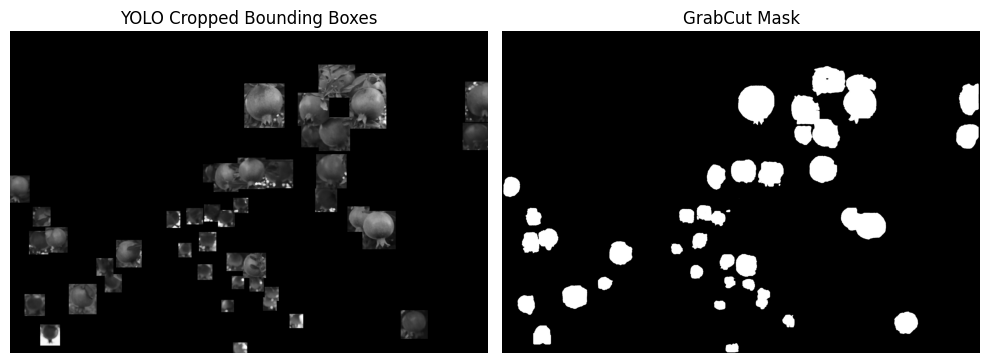

In [ ]:
yolo_model_path = r"/content/drive/MyDrive/Thesis/POM-IMG/Results_FT_TL/finetuned_model.pt"
rgb_image_path = r"/content/drive/MyDrive/Thesis/POM-IMG/pom_seg_img_code/image/FRAME 86.jpg"
mask_path = r"/content/drive/MyDrive/Thesis/POM-IMG/pom_seg_img_code/mask/FRAME 86.jpg"

# LOAD MODEL AND IMAGE
model = YOLO(yolo_model_path)
rgb_image = cv2.imread(rgb_image_path)
mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if rgb_image is None or mask_img is None:
    raise FileNotFoundError("Check your RGB or mask path.")

# INIT BLACK CANVAS SAME SIZE AS IMAGE
canvas = np.zeros_like(rgb_image)

# RUN YOLO AND PASTE CROP BACK IN PLACE
results = model(rgb_image_path)[0]
boxes = results.boxes.xyxy.cpu().numpy().astype(int)

for (x1, y1, x2, y2) in boxes:
    crop = rgb_image[y1:y2, x1:x2]
    if crop.shape[0] > 0 and crop.shape[1] > 0:
        canvas[y1:y2, x1:x2] = crop

# PREPARE FOR SSIM
canvas_gray = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
mask_gray = mask_img.astype(np.float32) / 255.0

# COMPUTE SSIM
ssim_score, _ = ssim(canvas_gray, mask_gray, full=True, data_range=1.0)

# DISPLAY SIDE BY SIDE
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(canvas_gray, cmap='gray')
axs[0].set_title("YOLO Cropped Bounding Boxes")
axs[0].axis("off")

axs[1].imshow(mask_gray, cmap='gray')
axs[1].set_title(f"GrabCut Mask")
axs[1].axis("off")

plt.tight_layout()
plt.show()
